In [6]:
import numpy as np
from scipy import optimize
from itertools import product

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

from gaus_vertex import *

In [64]:
poly_mat = [0,1,1]
dens = [1]
N = 1000
M = 3
N_m = N/M
b = 1

k0 = 1e-2
kf = 1e2
nk = 50

k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)

k1_vec = np.zeros((nk, 3))

k1_vec[:, 0] += np.logspace(np.log10(k0), np.log10(kf), nk)

In [44]:
# n_p = 1
# M = len(poly_mat)
# N = M*N_m

# ind = np.arange(0, M, 1)
# mon_pairs = np.array(np.meshgrid(poly_mat, poly_mat)).T.reshape(-1, 2) #list of all pairs of monomers
# ind_mesh = np.array(np.meshgrid(ind, ind)).T.reshape(-1, 2)
# dist = abs(ind_mesh[:,0] - ind_mesh[:, 1])

# corr_arr = np.zeros(M)
# alpha1 = 1
# alpha2 = 1
# alphas = np.array([alpha1,alpha2])
# for d in range(M):
#     pairs_d_apart = mon_pairs[np.where(dist==d)] #find all pairs d distance apart
#     comp_arr = (pairs_d_apart == alphas) #compare first column to alpha1, second column to alpha 2
#     sig12 = comp_arr[:,0] * comp_arr[:,1] #find pairs where both alphas are correct
#     pairs_d_sig = pairs_d_apart[sig12] #list of pairs d apart, of type (alpha1, alpha2)
#     corr_arr[d] = len(pairs_d_sig)*dens[0]#/len(pairs_d_apart)
# print(corr_arr)
# print(M2_BB)

[1. 0.]
[0. 1.]


In [65]:
def calc_monomer_tensor(poly_mat, dens, alpha1, alpha2):
    n_p = 1
    M = len(poly_mat)
    N = M*N_m
    
    ind = np.arange(0, M, 1)
    mon_pairs = np.array(np.meshgrid(poly_mat, poly_mat)).T.reshape(-1, 2) #list of all pairs of monomers
    ind_mesh = np.array(np.meshgrid(ind, ind)).T.reshape(-1, 2)
    dist = abs(ind_mesh[:,0] - ind_mesh[:, 1])

    corr_arr = np.zeros(M)
#     alpha1 = 0
#     alpha2 = 0
    alphas = np.array([alpha1,alpha2])
    for d in range(M):
        pairs_d_apart = mon_pairs[np.where(dist==d)] #find all pairs d distance apart
        comp_arr = (pairs_d_apart == alphas) #compare first column to alpha1, second column to alpha 2
        sig12 = comp_arr[:,0] * comp_arr[:,1] #find pairs where both alphas are correct
        pairs_d_sig = pairs_d_apart[sig12] #list of pairs d apart, of type (alpha1, alpha2)
        corr_arr[d] = len(pairs_d_sig)*dens[0]#/len(pairs_d_apart)
    return corr_arr

def calc_sf2_tensor(poly_mat, dens, N_m, b, k_vec = np.logspace(-2, 2, 50)):
    
    # TODO: use relations instead of recalculating cross correlation tensor!
    M2_AA = calc_monomer_tensor(poly_mat, dens, 0, 0)
    M2_AB = calc_monomer_tensor(poly_mat, dens, 0, 1)
    M2_BA = calc_monomer_tensor(poly_mat, dens, 1, 0)
    M2_BB = calc_monomer_tensor(poly_mat, dens, 1, 1)
#     M2_AB = M2_AA[j1, j1] - M2_AA
#     M2_BA = M2_AA[j2, j2] - M2_AA
#     M2_BB = 1 - M2_AA[j1, j1] - M2_AA[j2, j2] + M2_AA[j1, j2]

    M = np.shape(M2_AA)[0]
    nk = len(k_vec)
    N = M*N_m
    
    S2_AA_arr = np.zeros(nk)
    S2_AB_arr = np.zeros(nk)
    S2_BA_arr = np.zeros(nk)
    S2_BB_arr = np.zeros(nk)

    for i, k in enumerate(k_vec):
        C = np.zeros(M)
        k = np.linalg.norm(k)
        x_m = (1/6) * N_m * b**2 * k**2

        #j1 = j2, s1 > s2
        index = 0#(j1 == j2)
        constant = 1
        debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1) 

    #     C[np.where((index) != 0)] += debye
        C[0] += debye

        #j1 > j2, s1 s2 any
        index = np.arange(0, M, 1)#(j1 > j2) #index = del!
        constant = np.exp(-x_m*index)
        integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms

        C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral

        S2_AA_arr[i] = np.sum((1/M**2) * C * M2_AA)
        S2_AB_arr[i] = np.sum((1/M**2) * C * M2_AB)
        S2_BA_arr[i] = np.sum((1/M**2) * C * M2_BA)
        S2_BB_arr[i] = np.sum((1/M**2) * C * M2_BB)
    return S2_AA_arr*N**2, S2_AB_arr*N**2, S2_BA_arr*N**2, S2_BB_arr*N**2


In [66]:
%%time
s2_tensor_AA, s2_tensor_AB, s2_tensor_BA, s2_tensor_BB = calc_sf2_tensor(poly_mat, dens, N_m, b, k_vec)

Wall time: 11 ms


<ipython-input-65-acf6715758bd>:59: RuntimeWarning: overflow encountered in exp
  integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms
<ipython-input-65-acf6715758bd>:61: RuntimeWarning: invalid value encountered in multiply
  C[np.where((index) != 0)] += constant[np.where(index != 0)] \


In [67]:
%%time
s2_matrix_AA, s2_matrix_AB, s2_matrix_BA, s2_matrix_BB = calc_sf2(poly_mat, dens, N_m, b, k_vec)

Wall time: 20 ms


C:\Users\Thomas\Desktop\structure_factor\structure_factor\gaus_vertex.py:78: RuntimeWarning: overflow encountered in exp
  constant = np.exp(-x_m*(j1-j2))
C:\Users\Thomas\Desktop\structure_factor\structure_factor\gaus_vertex.py:86: RuntimeWarning: overflow encountered in exp
  constant = np.exp(-x_m*(j2-j1))
C:\Users\Thomas\Desktop\structure_factor\structure_factor\gaus_vertex.py:79: RuntimeWarning: overflow encountered in exp
  integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms
C:\Users\Thomas\Desktop\structure_factor\structure_factor\gaus_vertex.py:81: RuntimeWarning: invalid value encountered in multiply
  C[np.where((index) != 0)] += constant[np.where(index != 0)] \
C:\Users\Thomas\Desktop\structure_factor\structure_factor\gaus_vertex.py:89: RuntimeWarning: invalid value encountered in multiply
  C[np.where((index) != 0)] += constant[np.where(index != 0)] \


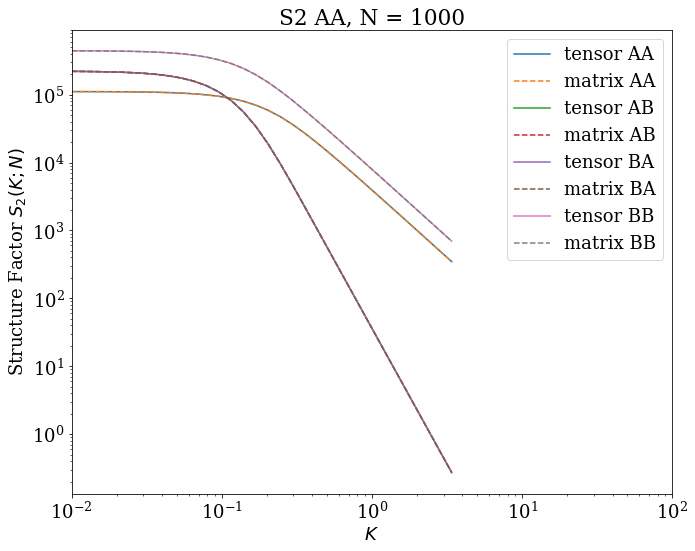

In [71]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.plot(k_vec, s2_tensor_AA, label = "tensor AA")
plt.plot(k_vec, s2_matrix_AA, label = "matrix AA", linestyle = "--")

plt.plot(k_vec, s2_tensor_AB, label = "tensor AB")
plt.plot(k_vec, s2_matrix_AB, label = "matrix AB", linestyle = "--")

plt.plot(k_vec, s2_tensor_BA, label = "tensor BA")
plt.plot(k_vec, s2_matrix_BA, label = "matrix BA", linestyle = "--")

plt.plot(k_vec, s2_tensor_BB, label = "tensor BB")
plt.plot(k_vec, s2_matrix_BB, label = "matrix BB", linestyle = "--")



plt.xscale('log')
plt.yscale('log')

plt.title("S2 AA, N = "+str(N))
plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{2}(K;N)$')
plt.xlim((1e-2, 1e2))
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
def calc_monomer_matrix(poly_mat, dens):
    # calculates the AA monomer identity cross correlation matrix
    # assumes all polymers same length/ # of monomers, equal volume fraction of each
    
    #polymat - each row is a polymer
    #dens is an array where each entry is rel vol frac of correponding polymer
    
    poly_mat = np.array(poly_mat)
    
    epsilon = 0.00001
    if not ((np.sum(dens) + epsilon > 1) and (np.sum(dens) - epsilon < 1)):
        raise Exception("polymer volumer fractions do not sum to one")
    if len(np.shape(poly_mat)) == 1: #single poly
        n_p = 1
        M = len(poly_mat)
        alph1 =np.zeros(M)
        alph2 =np.zeros(M)
        sig1 = 1*(poly_mat == alph1)
        sig2 = 1*(poly_mat == alph2)
        M2_AA = np.outer(sig1, sig2)
        return M2_AA
    
    n_p = poly_mat.shape[0]
    M = poly_mat.shape[1]
    alph1 =np.zeros((n_p, M))
    alph2 =np.zeros((n_p, M))
    
    #extend dens into n_pxM matrix
    poly_weights = (np.ones((n_p, M)).T * dens).T
    
    #multiply sigams by density of each polymer
    sigma1 = 1*((poly_mat == alph1))#.sum(axis = 0) #sigma. could multiply each
    sigma2 = 1*((poly_mat == alph2))#.sum(axis = 0)

    #need to do each row outer product with corresponding row, get n_p MxM matrices, then sum the results
    prods = np.einsum('bi,bo->bio', sigma1*poly_weights, sigma2) # performing row wise cross product (each poly contribution)
    M2_AA = np.sum(prods, axis = 0)#           ^^^^ averaging each contribution
    return M2_AA


def calc_sf2(poly_mat, dens, N_m=1, b=1, k_vec = np.logspace(-2, 2, 50)):
    M2_AA = calc_monomer_matrix(poly_mat, dens)
    M = np.shape(M2_AA)[0]
    nk = len(k_vec)
    N = M*N_m

    grid = np.indices((M, M))
    j1 = grid[0]
    j2 = grid[1]
    
    S2_AA_arr = np.zeros(nk)
    S2_AB_arr = np.zeros(nk)
    S2_BA_arr = np.zeros(nk)
    S2_BB_arr = np.zeros(nk)
    
    M2_AB = M2_AA[j1, j1] - M2_AA
    M2_BA = M2_AA[j2, j2] - M2_AA
    M2_BB = 1 - M2_AA[j1, j1] - M2_AA[j2, j2] + M2_AA[j1, j2]
#     print(M2_AA)
    
    for i, k in enumerate(k_vec):
        C = np.zeros((M, M))
        k = np.linalg.norm(k)
        x_m = (1/6) * N_m * b**2 * k**2

        #j1 = j2, s1 > s2
        index = (j1 == j2)
        constant = 1
        debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1) 
        
        C[np.where((index) != 0)] += debye
        
        #j1 > j2, s1 s2 any
        index = (j1 > j2)
        constant = np.exp(-x_m*(j1-j2))
        integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms

        C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral
        
        #j2 > j1, s1 s2 any
        index = (j2 > j1)
        constant = np.exp(-x_m*(j2-j1))
#         integral is the same

        C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral   
#         print(C/M**2)
        S2_AA_arr[i] = np.sum((1/M**2) * C * M2_AA)
        S2_AB_arr[i] = np.sum((1/M**2) * C * M2_AB)
        S2_BA_arr[i] = np.sum((1/M**2) * C * M2_BA)
        S2_BB_arr[i] = np.sum((1/M**2) * C * M2_BB)
#         print(C)
    return S2_AA_arr*N**2, S2_AB_arr*N**2, S2_BA_arr*N**2, S2_BB_arr*N**2


In [ ]:
#generate cross correlation rank 1 tensor, DEL

# find each pair del apart
#of those, which fraction has coorect connectivity according to alpha values
# this fraction is the value of the tensor at DEL

# get monodisperse first, then deal with mix, length polydispersity

In [ ]:
# option 1; O n**2
# poly = [0]*50 + [1]*50
# N_m = 100

poly = [0,1]
N_m = 2

ind = np.arange(0, N_m, 1)
points = np.array(np.meshgrid(poly, poly)).T.reshape(-1, 2)
ind_mesh = np.array(np.meshgrid(ind, ind)).T.reshape(-1, 2)
dist = abs(ind_mesh[:,0] - ind_mesh[:, 1])
points

In [ ]:
dist

In [ ]:
#find all points DIST appart, of type alpha1, alpha2
DIST = 1

alpha1 = 0
alpha2 = 1
alphas = np.array([alpha1,alpha2])

points_at_DIST = points[np.where(dist==DIST)] #find all points DIST away
comp_arr = (points_at_DIST == alphas) #compare first column to alpha1, second column to alpha 2
sig12 = comp_arr[:,0] * comp_arr[:,1] #find points where both alphas are correct
pnts_DIST_sig = points_at_DIST[sig12]

In [ ]:
len(pnts_DIST_sig)/len(points_at_DIST)

In [ ]:
corr_arr

In [ ]:
# option 2 not functional but faster
# Function to perform merge sort
# Time Complexity : O(N logN) (np.meshgri : O(N**2))
# Space Complexity : O(N) + O(Number Of Pairs)
def getPairsMerge(arr, l, r, mid, p, index):
    b = [0 for _ in range(l + r + 1)]
    i=l
    k=l
    j=mid+1;
    while(i<=mid and j<=r):
        d_ij = abs(index[i]-index[j]) #distance bw i and j
        if(arr[i]>arr[j]):
            b[k]=arr[j];
            p.append([np.array([arr[i],arr[j]]), d_ij]);
            p.append([np.array([arr[j],arr[i]]), d_ij]);
            p.append([np.array([arr[j],arr[j]]), 0]);
            k+= 1;
            j+= 1;
         
        else:
            p.append([np.array([arr[i],arr[j]]), d_ij]);
            p.append([np.array([arr[j],arr[i]]), d_ij]);
            p.append([np.array([arr[i],arr[i]]), 0]);
            b[k]=arr[i];
            i+= 1;
            k+= 1;
         
     
    while(i<=mid):
        b[k]=arr[i];
        p.append([np.array([arr[i],arr[i]]), 0]);
        i+= 1;
        k+= 1;
     
    while(j<=r):
        b[k]=arr[j];
        p.append([np.array([arr[j],arr[j]]), 0]);
        j+= 1;
        k+= 1;
     
    for x in range(l, r + 1):
        arr[x]=b[x];
     
 
 
# Function to get all pairs
def getAllPairs(arr, l, r, p, index):
 
    if(l<r):
#         mid=int((l+r)/2);
#         getAllPairs(arr,l,mid,p, index[:mid+1]);
#         getAllPairs(arr,mid+1,r,p, index[mid+1:]);
#         getPairsMerge(arr,l,r,mid,p, index)
        mid=int((l+r)/2);
        getAllPairs(arr,l,mid,p, index);
        getAllPairs(arr,mid+1,r,p, index);
        getPairsMerge(arr,l,r,mid,p, index);
 



In [ ]:
# Driver code
 
n=4;
arr = [0 for _ in range(n)]
arr[0] = 1
arr[1] = 2
arr[2] = 3
arr[3] = 4
p = []
getAllPairs(arr,0,n-1,p, np.arange(0,n, 1))
# Displaying the sorted pairs
for it in p:
    print(it[0], it[1])

In [ ]:
parr = np.array(p)
parr[:,0]

In [ ]:
parr[:,1]

In [ ]:
np.where(parr[:, 0] == np.array([1,1]))